In [2]:
import torch
import pytorch_lightning as pl
from pretrain_IJEPA import IJEPA
import os
from torchviz import make_dot

In [3]:
# Path to checkpoint
#checkpoint_path = "lightning_logs/version_0/checkpoints/epoch=9-step=70.ckpt"
checkpoint_path = "checkpoints/small/ijepa-64px-epoch=00.ckpt"

# Check if checkpoint exists
if not os.path.exists(checkpoint_path):
    print(f"Checkpoint not found at {checkpoint_path}")
else:
    # Load the model from checkpoint
    print(f"Loading checkpoint from {checkpoint_path}")
    model = IJEPA.load_from_checkpoint(checkpoint_path)


Loading checkpoint from checkpoints/small/ijepa-64px-epoch=00.ckpt


c:\Users\agnish\anaconda3\envs\diffusion\lib\site-packages\lightning_fabric\utilities\cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


## Model Hyperparameters

In [4]:
# Print model hyperparameters
for key, value in model.hparams.items():
    print(f"{key}: {value}")


img_size: 64
patch_size: 8
in_chans: 3
embed_dim: 128
enc_heads: 4
enc_depth: 6
decoder_depth: 2
lr: 0.001
weight_decay: 0.05
target_aspect_ratio: (0.75, 1.5)
target_scale: (0.15, 0.2)
context_aspect_ratio: 1.0
context_scale: (0.85, 1.0)
M: 4
m: 0.996
m_start_end: (0.996, 1.0)


## Model Architecture


In [5]:
# Print model architecture summary
print(f"Student Encoder: {model.model.student_encoder.__class__.__name__}")
print(f"Teacher Encoder: {model.model.teacher_encoder.__class__.__name__}")
print(f"Predictor: {model.model.predictor.__class__.__name__}")

Student Encoder: Encoder
Teacher Encoder: Encoder
Predictor: Predictor


## Parameter Count

In [6]:
# Print model parameters count
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 3,716,224
Trainable parameters: 3,716,224


## Additional Model Information


In [7]:
# Print additional model info
print(f"Number of target blocks (M): {model.M}")
print(f"Embedding dimension: {model.embed_dim}")
print(f"Patch size: {model.patch_size}")
print(f"Number of tokens: {model.num_tokens}")


Number of target blocks (M): 4
Embedding dimension: 128
Patch size: 8
Number of tokens: 64


## Visualize Model Structure


In [8]:
# Optional: Print detailed model structure
print(model)

IJEPA(
  (model): IJEPA_base(
    (patch_embed): PatchEmbed(
      (conv): Conv2d(3, 128, kernel_size=(8, 8), stride=(8, 8))
    )
    (post_emb_norm): Identity()
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (teacher_encoder): Encoder(
      (layers): ModuleList(
        (0): ModuleList(
          (0): ModuleList(
            (0): LayerNorm(
              (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
            )
            (1-2): 2 x None
          )
          (1): Attention(
            (to_q): Linear(in_features=128, out_features=256, bias=False)
            (to_k): Linear(in_features=128, out_features=256, bias=False)
            (to_v): Linear(in_features=128, out_features=256, bias=False)
            (split_q_heads): Rearrange('b n (h d) -> b h n d', h=4)
            (split_k_heads): Rearrange('b n (h d) -> b h n d', d=64)
            (split_v_heads): Rearrange('b n (h d) -> b h n d', d=64)
            (merge_heads): Rearrange('b h n d ->

## Examine Specific Layer Weights


In [9]:
x = torch.randn((10, 3, 64, 64)).to(device='cuda')  # sequence of token IDs
output = model(x, target_aspect_ratio=1, target_scale=1, context_aspect_ratio=1, context_scale=1)
#make_dot(output, params=dict(model.named_parameters())).render("model", format="png")
torch.onnx.export(model, (x, 1, 1, 1, 1), "model.onnx", input_names=["input"], output_names=["output"])

c:\Users\agnish\anaconda3\envs\diffusion\lib\site-packages\x_transformers\attend.py:437: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if n == 1 and causal:
c:\Users\agnish\anaconda3\envs\diffusion\lib\site-packages\x_transformers\attend.py:442: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if kv_heads == 1:
c:\Users\agnish\anaconda3\envs\diffusion\lib\site-packages\x_transformers\attend.py:444: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value wil

: 

In [ ]:
# Compare with teacher encoder's corresponding layer
teacher_layer = model.model.teacher_encoder.layers[0]

print("Comparing student and teacher encoder layers:")
print("-" * 50)

# Get state dicts for both layers
student_state = specific_layer.state_dict()
teacher_state = teacher_layer.state_dict()

# Compare parameters for each key in state dict
for key in student_state.keys():
    if key in teacher_state:
        student_param = student_state[key]
        teacher_param = teacher_state[key]
        
        if student_param.shape == teacher_param.shape:
            # Calculate statistics
            student_mean = student_param.mean().item()
            teacher_mean = teacher_param.mean().item()
            student_std = student_param.std().item()
            teacher_std = teacher_param.std().item()
            
            print(f"\nParameter: {key}")
            print(f"Mean - Student: {student_mean:.6f}, Teacher: {teacher_mean:.6f}")
            print(f"Std  - Student: {student_std:.6f}, Teacher: {teacher_std:.6f}")
            
            # Calculate similarity metrics
            # Cosine similarity
            student_flat = student_param.flatten()
            teacher_flat = teacher_param.flatten()
            cos_sim = torch.nn.functional.cosine_similarity(student_flat, teacher_flat, dim=0)
            print(f"Cosine similarity: {cos_sim.item():.6f}")
            
            # L2 distance
            l2_dist = torch.norm(student_param - teacher_param).item()
            print(f"L2 distance: {l2_dist:.6f}")
        else:
            print(f"\nParameter: {key}")
            print(f"Shapes differ - Student: {student_param.shape}, Teacher: {teacher_param.shape}")
    else:
        print(f"\nParameter {key} exists in student but not in teacher")

# Check for parameters in teacher but not in student
for key in teacher_state.keys():
    if key not in student_state:
        print(f"\nParameter {key} exists in teacher but not in student")


Comparing student and teacher encoder layers:
--------------------------------------------------

Parameter: 0.0.gamma
Mean - Student: -0.049694, Teacher: -0.033852
Std  - Student: 0.027912, Teacher: 0.021492
Cosine similarity: 0.996385
L2 distance: 0.196530

Parameter: 1.to_q.weight
Mean - Student: 0.000428, Teacher: 0.000431
Std  - Student: 0.054726, Teacher: 0.053226
Cosine similarity: 0.990926
L2 distance: 1.343833

Parameter: 1.to_k.weight
Mean - Student: 0.000233, Teacher: 0.000220
Std  - Student: 0.054352, Teacher: 0.053042
Cosine similarity: 0.991540
L2 distance: 1.286318

Parameter: 1.to_v.weight
Mean - Student: 0.000091, Teacher: 0.000099
Std  - Student: 0.048634, Teacher: 0.049313
Cosine similarity: 0.996382
L2 distance: 0.763996

Parameter: 1.to_out.weight
Mean - Student: -0.000060, Teacher: -0.000053
Std  - Student: 0.035202, Teacher: 0.035188
Cosine similarity: 0.990941
L2 distance: 0.857519


In [ ]:
# Compare with teacher encoder's corresponding layer
teacher_layer = model.model.teacher_encoder.layers[0]

print("Comparing student and teacher encoder layers:")
print("-" * 50)

# Get state dicts for both layers
student_state = specific_layer.state_dict()
teacher_state = teacher_layer.state_dict()

# Compare parameters for each key in state dict
for key in student_state.keys():
    if key in teacher_state:
        student_param = student_state[key]
        teacher_param = teacher_state[key]
        
        if student_param.shape == teacher_param.shape:
            # Calculate statistics
            student_mean = student_param.mean().item()
            teacher_mean = teacher_param.mean().item()
            student_std = student_param.std().item()
            teacher_std = teacher_param.std().item()
            
            print(f"\nParameter: {key}")
            print(f"Mean - Student: {student_mean:.6f}, Teacher: {teacher_mean:.6f}")
            print(f"Std  - Student: {student_std:.6f}, Teacher: {teacher_std:.6f}")
            
            # Calculate similarity metrics
            # Cosine similarity
            student_flat = student_param.flatten()
            teacher_flat = teacher_param.flatten()
            cos_sim = torch.nn.functional.cosine_similarity(student_flat, teacher_flat, dim=0)
            print(f"Cosine similarity: {cos_sim.item():.6f}")
            
            # L2 distance
            l2_dist = torch.norm(student_param - teacher_param).item()
            print(f"L2 distance: {l2_dist:.6f}")
        else:
            print(f"\nParameter: {key}")
            print(f"Shapes differ - Student: {student_param.shape}, Teacher: {teacher_param.shape}")
    else:
        print(f"\nParameter {key} exists in student but not in teacher")

# Check for parameters in teacher but not in student
for key in teacher_state.keys():
    if key not in student_state:
        print(f"\nParameter {key} exists in teacher but not in student")


Comparing student and teacher encoder layers:
--------------------------------------------------

Parameter: 0.0.gamma
Mean - Student: -0.049694, Teacher: -0.033852
Std  - Student: 0.027912, Teacher: 0.021492
Cosine similarity: 0.996385
L2 distance: 0.196530

Parameter: 1.to_q.weight
Mean - Student: 0.000428, Teacher: 0.000431
Std  - Student: 0.054726, Teacher: 0.053226
Cosine similarity: 0.990926
L2 distance: 1.343833

Parameter: 1.to_k.weight
Mean - Student: 0.000233, Teacher: 0.000220
Std  - Student: 0.054352, Teacher: 0.053042
Cosine similarity: 0.991540
L2 distance: 1.286318

Parameter: 1.to_v.weight
Mean - Student: 0.000091, Teacher: 0.000099
Std  - Student: 0.048634, Teacher: 0.049313
Cosine similarity: 0.996382
L2 distance: 0.763996

Parameter: 1.to_out.weight
Mean - Student: -0.000060, Teacher: -0.000053
Std  - Student: 0.035202, Teacher: 0.035188
Cosine similarity: 0.990941
L2 distance: 0.857519


Layer type: ModuleList
Layer attributes: ['T_destination', '__add__', '__annotations__', '__call__', '__class__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_abs_string_index', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre

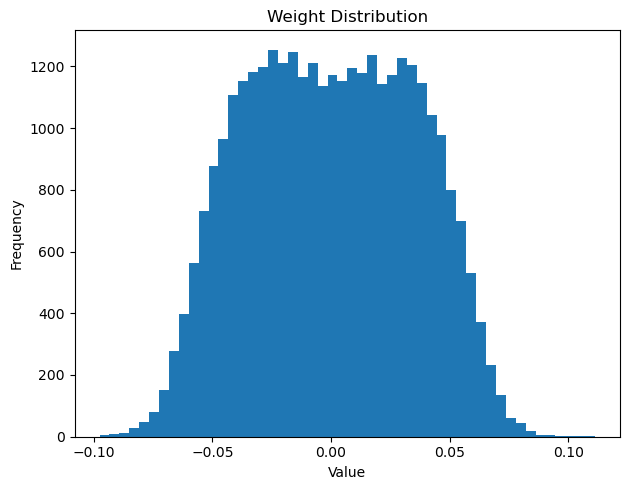

In [9]:
# Access the specific layer: model.model.student_encoder.layers[0][0][0].ln
specific_layer = model.model.student_encoder.layers[0]

# Display layer type and structure
print(f"Layer type: {type(specific_layer).__name__}")
print(f"Layer attributes: {dir(specific_layer)}")
print(f"Layer state_dict keys: {specific_layer.state_dict().keys()}")

# Inspect the layer's parameters
print("\nParameters:")
for name, param in specific_layer.named_parameters():
    print(f"  - {name}: {param.shape}")

# Inspect the layer's buffers
print("\nBuffers:")
for name, buffer in specific_layer.named_buffers():
    print(f"  - {name}: {buffer.shape}")

# Inspect the state dict
print("\nState Dict:")
for key, value in specific_layer.state_dict().items():
    print(f"  - {key}: {value.shape}")
    print(f"    First few values: {value.flatten()[:5]}")
    print(f"    Mean: {value.mean().item():.6f}, Std: {value.std().item():.6f}")

# Safer way to display weights and bias
weight = None
bias = None

for name, param in specific_layer.named_parameters():
    if 'weight' in name:
        weight = param
    elif 'bias' in name:
        bias = param

# If we didn't find them in parameters, check state_dict
if weight is None and 'weight' in specific_layer.state_dict():
    weight = specific_layer.state_dict()['weight']
if bias is None and 'bias' in specific_layer.state_dict():
    bias = specific_layer.state_dict()['bias']

# Now display weight info if found
if weight is not None:
    print("\nWeight shape:", weight.shape)
    print(f"Weight values (first 10):\n{weight[:10]}")
    print(f"Weight statistics:")
    print(f"  Mean: {weight.mean().item():.6f}")
    print(f"  Std: {weight.std().item():.6f}")
    print(f"  Min: {weight.min().item():.6f}")
    print(f"  Max: {weight.max().item():.6f}")
else:
    print("\nNo weight parameter found in this layer")

# Display bias info if found
if bias is not None:
    print("\nBias shape:", bias.shape)
    print(f"Bias values (first 10):\n{bias[:10]}")
    print(f"Bias statistics:")
    print(f"  Mean: {bias.mean().item():.6f}")
    print(f"  Std: {bias.std().item():.6f}")
    print(f"  Min: {bias.min().item():.6f}")
    print(f"  Max: {bias.max().item():.6f}")
else:
    print("\nNo bias parameter found in this layer")

# Display histogram of weights
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 5))
    
    if weight is not None:
        plt.subplot(1, 2, 1)
        plt.hist(weight.detach().flatten().cpu().numpy(), bins=50)
        plt.title('Weight Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    
    if bias is not None:
        plt.subplot(1, 2, 2 if weight is not None else 1, 1)
        plt.hist(bias.detach().flatten().cpu().numpy(), bins=50)
        plt.title('Bias Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib not available for histogram visualization")
except Exception as e:
    print(f"Error creating histogram: {e}")


## Save Layer Weights to File


In [10]:
# Save the weights to a file for further analysis
import numpy as np

# Function to save layer weights
def save_layer_weights(layer, filename_prefix="layer_weights"):
    """Save layer weights and bias to numpy files"""
    # Get weights and biases from state_dict
    state_dict = layer.state_dict()
    
    for key, value in state_dict.items():
        if value is not None:
            np_value = value.detach().cpu().numpy()
            np.save(f"{filename_prefix}_{key}.npy", np_value)
            print(f"{key} saved to {filename_prefix}_{key}.npy")

# Save the specific layer weights
save_layer_weights(specific_layer, "student_encoder_layer0_ln")


0.0.gamma saved to student_encoder_layer0_ln_0.0.gamma.npy
1.to_q.weight saved to student_encoder_layer0_ln_1.to_q.weight.npy
1.to_k.weight saved to student_encoder_layer0_ln_1.to_k.weight.npy
1.to_v.weight saved to student_encoder_layer0_ln_1.to_v.weight.npy
1.to_out.weight saved to student_encoder_layer0_ln_1.to_out.weight.npy


## Compare with Other Layers


In [11]:
# Compare with teacher encoder's corresponding layer
teacher_layer = model.model.teacher_encoder.layers[0]

print("Comparing student and teacher encoder layers:")
print("-" * 50)

# Get state dicts for both layers
student_state = specific_layer.state_dict()
teacher_state = teacher_layer.state_dict()

# Compare parameters for each key in state dict
for key in student_state.keys():
    if key in teacher_state:
        student_param = student_state[key]
        teacher_param = teacher_state[key]
        
        if student_param.shape == teacher_param.shape:
            # Calculate statistics
            student_mean = student_param.mean().item()
            teacher_mean = teacher_param.mean().item()
            student_std = student_param.std().item()
            teacher_std = teacher_param.std().item()
            
            print(f"\nParameter: {key}")
            print(f"Mean - Student: {student_mean:.6f}, Teacher: {teacher_mean:.6f}")
            print(f"Std  - Student: {student_std:.6f}, Teacher: {teacher_std:.6f}")
            
            # Calculate similarity metrics
            # Cosine similarity
            student_flat = student_param.flatten()
            teacher_flat = teacher_param.flatten()
            cos_sim = torch.nn.functional.cosine_similarity(student_flat, teacher_flat, dim=0)
            print(f"Cosine similarity: {cos_sim.item():.6f}")
            
            # L2 distance
            l2_dist = torch.norm(student_param - teacher_param).item()
            print(f"L2 distance: {l2_dist:.6f}")
        else:
            print(f"\nParameter: {key}")
            print(f"Shapes differ - Student: {student_param.shape}, Teacher: {teacher_param.shape}")
    else:
        print(f"\nParameter {key} exists in student but not in teacher")

# Check for parameters in teacher but not in student
for key in teacher_state.keys():
    if key not in student_state:
        print(f"\nParameter {key} exists in teacher but not in student")


Comparing student and teacher encoder layers:
--------------------------------------------------

Parameter: 0.0.gamma
Mean - Student: -0.049694, Teacher: -0.033852
Std  - Student: 0.027912, Teacher: 0.021492
Cosine similarity: 0.996385
L2 distance: 0.196530

Parameter: 1.to_q.weight
Mean - Student: 0.000428, Teacher: 0.000431
Std  - Student: 0.054726, Teacher: 0.053226
Cosine similarity: 0.990926
L2 distance: 1.343833

Parameter: 1.to_k.weight
Mean - Student: 0.000233, Teacher: 0.000220
Std  - Student: 0.054352, Teacher: 0.053042
Cosine similarity: 0.991540
L2 distance: 1.286318

Parameter: 1.to_v.weight
Mean - Student: 0.000091, Teacher: 0.000099
Std  - Student: 0.048634, Teacher: 0.049313
Cosine similarity: 0.996382
L2 distance: 0.763996

Parameter: 1.to_out.weight
Mean - Student: -0.000060, Teacher: -0.000053
Std  - Student: 0.035202, Teacher: 0.035188
Cosine similarity: 0.990941
L2 distance: 0.857519


In [ ]:
# Compare with teacher encoder's corresponding layer
teacher_layer = model.model.teacher_encoder.layers[0]

print("Comparing student and teacher encoder layers:")
print("-" * 50)

# Get state dicts for both layers
student_state = specific_layer.state_dict()
teacher_state = teacher_layer.state_dict()

# Compare parameters for each key in state dict
for key in student_state.keys():
    if key in teacher_state:
        student_param = student_state[key]
        teacher_param = teacher_state[key]
        
        if student_param.shape == teacher_param.shape:
            # Calculate statistics
            student_mean = student_param.mean().item()
            teacher_mean = teacher_param.mean().item()
            student_std = student_param.std().item()
            teacher_std = teacher_param.std().item()
            
            print(f"\nParameter: {key}")
            print(f"Mean - Student: {student_mean:.6f}, Teacher: {teacher_mean:.6f}")
            print(f"Std  - Student: {student_std:.6f}, Teacher: {teacher_std:.6f}")
            
            # Calculate similarity metrics
            # Cosine similarity
            student_flat = student_param.flatten()
            teacher_flat = teacher_param.flatten()
            cos_sim = torch.nn.functional.cosine_similarity(student_flat, teacher_flat, dim=0)
            print(f"Cosine similarity: {cos_sim.item():.6f}")
            
            # L2 distance
            l2_dist = torch.norm(student_param - teacher_param).item()
            print(f"L2 distance: {l2_dist:.6f}")
        else:
            print(f"\nParameter: {key}")
            print(f"Shapes differ - Student: {student_param.shape}, Teacher: {teacher_param.shape}")
    else:
        print(f"\nParameter {key} exists in student but not in teacher")

# Check for parameters in teacher but not in student
for key in teacher_state.keys():
    if key not in student_state:
        print(f"\nParameter {key} exists in teacher but not in student")


Comparing student and teacher encoder layers:
--------------------------------------------------

Parameter: 0.0.gamma
Mean - Student: -0.049694, Teacher: -0.033852
Std  - Student: 0.027912, Teacher: 0.021492
Cosine similarity: 0.996385
L2 distance: 0.196530

Parameter: 1.to_q.weight
Mean - Student: 0.000428, Teacher: 0.000431
Std  - Student: 0.054726, Teacher: 0.053226
Cosine similarity: 0.990926
L2 distance: 1.343833

Parameter: 1.to_k.weight
Mean - Student: 0.000233, Teacher: 0.000220
Std  - Student: 0.054352, Teacher: 0.053042
Cosine similarity: 0.991540
L2 distance: 1.286318

Parameter: 1.to_v.weight
Mean - Student: 0.000091, Teacher: 0.000099
Std  - Student: 0.048634, Teacher: 0.049313
Cosine similarity: 0.996382
L2 distance: 0.763996

Parameter: 1.to_out.weight
Mean - Student: -0.000060, Teacher: -0.000053
Std  - Student: 0.035202, Teacher: 0.035188
Cosine similarity: 0.990941
L2 distance: 0.857519


In [ ]:
# Compare with teacher encoder's corresponding layer
teacher_layer = model.model.teacher_encoder.layers[0]

print("Comparing student and teacher encoder layers:")
print("-" * 50)

# Get state dicts for both layers
student_state = specific_layer.state_dict()
teacher_state = teacher_layer.state_dict()

# Compare parameters for each key in state dict
for key in student_state.keys():
    if key in teacher_state:
        student_param = student_state[key]
        teacher_param = teacher_state[key]
        
        if student_param.shape == teacher_param.shape:
            # Calculate statistics
            student_mean = student_param.mean().item()
            teacher_mean = teacher_param.mean().item()
            student_std = student_param.std().item()
            teacher_std = teacher_param.std().item()
            
            print(f"\nParameter: {key}")
            print(f"Mean - Student: {student_mean:.6f}, Teacher: {teacher_mean:.6f}")
            print(f"Std  - Student: {student_std:.6f}, Teacher: {teacher_std:.6f}")
            
            # Calculate similarity metrics
            # Cosine similarity
            student_flat = student_param.flatten()
            teacher_flat = teacher_param.flatten()
            cos_sim = torch.nn.functional.cosine_similarity(student_flat, teacher_flat, dim=0)
            print(f"Cosine similarity: {cos_sim.item():.6f}")
            
            # L2 distance
            l2_dist = torch.norm(student_param - teacher_param).item()
            print(f"L2 distance: {l2_dist:.6f}")
        else:
            print(f"\nParameter: {key}")
            print(f"Shapes differ - Student: {student_param.shape}, Teacher: {teacher_param.shape}")
    else:
        print(f"\nParameter {key} exists in student but not in teacher")

# Check for parameters in teacher but not in student
for key in teacher_state.keys():
    if key not in student_state:
        print(f"\nParameter {key} exists in teacher but not in student")


Comparing student and teacher encoder layers:
--------------------------------------------------

Parameter: 0.0.gamma
Mean - Student: -0.049694, Teacher: -0.033852
Std  - Student: 0.027912, Teacher: 0.021492
Cosine similarity: 0.996385
L2 distance: 0.196530

Parameter: 1.to_q.weight
Mean - Student: 0.000428, Teacher: 0.000431
Std  - Student: 0.054726, Teacher: 0.053226
Cosine similarity: 0.990926
L2 distance: 1.343833

Parameter: 1.to_k.weight
Mean - Student: 0.000233, Teacher: 0.000220
Std  - Student: 0.054352, Teacher: 0.053042
Cosine similarity: 0.991540
L2 distance: 1.286318

Parameter: 1.to_v.weight
Mean - Student: 0.000091, Teacher: 0.000099
Std  - Student: 0.048634, Teacher: 0.049313
Cosine similarity: 0.996382
L2 distance: 0.763996

Parameter: 1.to_out.weight
Mean - Student: -0.000060, Teacher: -0.000053
Std  - Student: 0.035202, Teacher: 0.035188
Cosine similarity: 0.990941
L2 distance: 0.857519


## Explore Layer Structure


In [33]:
# Let's explore the structure of the model to understand how to access layer weights
print("Exploring model.model.student_encoder.layers[0][0][0].ln structure:")

# First, check what type of layer this is
layer = model.model.student_encoder.layers[0][0][0].ln
print(f"Layer class: {layer.__class__.__name__}")
print(f"Layer module path: {layer.__class__.__module__}")

# Check if this is a PyTorch LayerNorm
if isinstance(layer, torch.nn.LayerNorm):
    print("\nThis is a standard PyTorch LayerNorm layer")
    print(f"Normalized shape: {layer.normalized_shape}")
    print(f"Epsilon: {layer.eps}")
    print(f"Element-wise affine: {layer.elementwise_affine}")
    
    # Check if weights are registered as parameters
    for name, param in layer.named_parameters():
        print(f"\nParameter: {name}")
        print(f"  Shape: {param.shape}")
        print(f"  Requires grad: {param.requires_grad}")
        print(f"  First few values: {param.data.flatten()[:5]}")
        
# Try to access _parameters dictionary directly
print("\nDirect access to _parameters dictionary:")
if hasattr(layer, '_parameters'):
    for name, param in layer._parameters.items():
        if param is not None:
            print(f"  {name}: {param.shape}")
        else:
            print(f"  {name}: None")
else:
    print("  No _parameters attribute found")

# Check if there are any registered buffers
print("\nRegistered buffers:")
if hasattr(layer, '_buffers'):
    for name, buffer in layer._buffers.items():
        if buffer is not None:
            print(f"  {name}: {buffer.shape}")
        else:
            print(f"  {name}: None")
else:
    print("  No _buffers attribute found")

# Print the module's children
print("\nModule children:")
has_children = False
for i, child in enumerate(layer.children()):
    has_children = True
    print(f"  Child {i}: {child.__class__.__name__}")
if not has_children:
    print("  No children modules")

# Print the full repr of the layer
print("\nFull layer representation:")
print(layer)


Exploring model.model.student_encoder.layers[0][0][0].ln structure:
Layer class: LayerNorm
Layer module path: torch.nn.modules.normalization

This is a standard PyTorch LayerNorm layer
Normalized shape: (64,)
Epsilon: 1e-05
Element-wise affine: False

Direct access to _parameters dictionary:
  weight: None
  bias: None

Registered buffers:

Module children:
  No children modules

Full layer representation:
LayerNorm((64,), eps=1e-05, elementwise_affine=False)


## Investigate Model Architecture


In [34]:
# Let's look at the model.py file to understand the architecture
import inspect

# Check if we can import the model module
try:
    import model as model_module
    
    # Get the source code of the IJEPA_base class
    if hasattr(model_module, 'IJEPA_base'):
        print("Found IJEPA_base class in model module")
        print("\nClass definition:")
        print(inspect.getsource(model_module.IJEPA_base))
    else:
        print("IJEPA_base class not found in model module")
        
    # List all classes in the module
    print("\nAll classes in model module:")
    for name, obj in inspect.getmembers(model_module, inspect.isclass):
        print(f"  - {name}")
        
except ImportError:
    print("Could not import model module")
    
# Let's also check the structure of the student encoder
student_encoder = model.model.student_encoder
print("\nStudent Encoder Structure:")
print(f"Type: {type(student_encoder).__name__}")

# Check the layers structure
print("\nLayers structure:")
print(f"Type of layers: {type(student_encoder.layers).__name__}")
print(f"Length of layers: {len(student_encoder.layers)}")

# Check the first layer
print("\nFirst layer structure:")
print(f"Type of first layer: {type(student_encoder.layers[0]).__name__}")
print(f"Length of first layer: {len(student_encoder.layers[0])}")

# Check the structure of layers[0][0]
print("\nLayers[0][0] structure:")
print(f"Type: {type(student_encoder.layers[0][0]).__name__}")
print(f"Length: {len(student_encoder.layers[0][0])}")

# Check the structure of layers[0][0][0]
print("\nLayers[0][0][0] structure:")
for name, module in student_encoder.layers[0][0][0].named_children():
    print(f"  - {name}: {type(module).__name__}")

# Check if elementwise_affine is True for the layer norm
ln_layer = student_encoder.layers[0][0][0].ln
if hasattr(ln_layer, 'elementwise_affine'):
    print(f"\nLayerNorm elementwise_affine: {ln_layer.elementwise_affine}")
else:
    print("\nLayerNorm does not have elementwise_affine attribute")


Found IJEPA_base class in model module

Class definition:
class IJEPA_base(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim, enc_depth, pred_depth, num_heads, post_emb_norm=False, M = 4, mode="train", layer_dropout=0.):
        super().__init__()
        self.M = M
        self.mode = mode
        self.layer_dropout = layer_dropout

        #define the patch embedding and positional embedding
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        self.patch_dim  = (self.patch_embed.patch_shape[0], self.patch_embed.patch_shape[1])
        self.num_tokens = self.patch_embed.patch_shape[0] * self.patch_embed.patch_shape[1]
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, embed_dim))

        #define the cls and mask tokens
        self.mask_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        nn.init.trunc_normal_(self.mask_token, 0.02)

        #define the e

## Alternative Way to Access Layer Weights


In [35]:
# If the layer is a LayerNorm with elementwise_affine=False, it won't have weight/bias attributes
# Let's try to access the layer weights through the model's state_dict instead

# Get the full state_dict
full_state_dict = model.state_dict()

# Find keys related to our layer
target_prefix = "model.student_encoder.layers.0.0.0.ln"
matching_keys = [k for k in full_state_dict.keys() if k.startswith(target_prefix)]

print(f"Found {len(matching_keys)} keys matching '{target_prefix}':")
for key in matching_keys:
    param = full_state_dict[key]
    print(f"\nKey: {key}")
    print(f"  Shape: {param.shape}")
    print(f"  Type: {param.dtype}")
    print(f"  First few values: {param.flatten()[:5]}")
    print(f"  Mean: {param.mean().item():.6f}, Std: {param.std().item():.6f}")

# If we found matching keys, let's visualize one of them
if matching_keys:
    try:
        import matplotlib.pyplot as plt
        
        key = matching_keys[0]  # Take the first matching key
        values = full_state_dict[key].detach().cpu().numpy().flatten()
        
        plt.figure(figsize=(10, 5))
        plt.hist(values, bins=50)
        plt.title(f'Distribution of {key}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("Matplotlib not available for visualization")
    except Exception as e:
        print(f"Error creating visualization: {e}")
else:
    # If no keys found, try a broader search
    print("\nNo keys found with exact prefix. Trying a broader search...")
    broader_prefix = "model.student_encoder"
    matching_keys = [k for k in full_state_dict.keys() if broader_prefix in k and "ln" in k and "0.0.0" in k]
    
    print(f"Found {len(matching_keys)} keys with broader search:")
    for key in matching_keys:
        param = full_state_dict[key]
        print(f"  {key}: {param.shape}")


Found 0 keys matching 'model.student_encoder.layers.0.0.0.ln':

No keys found with exact prefix. Trying a broader search...
Found 0 keys with broader search:
